# Data 불러와서 전처리하기

In [1]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torch
import torchvision as tv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

trans = transforms.Compose([transforms.Resize((300, 300)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = tv.datasets.ImageFolder(root='./dataset', transform=trans)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=8)

datalist = list(dataloader)

slicer1, slicer2 = int(len(datalist)*0.8), int(len(datalist)*0.9)
trainset = datalist[:slicer1]
valset = datalist[slicer1:slicer2]
testset = datalist[slicer2:]

# img = cv2.imread(str(imgs/f'{img_names[0]}.jpg'), 1)
# cv2.imshow('test', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# 테스트데이터 일부 시각화

(3, 1210, 1210)
(1210, 1210, 3)
['snow ', 'lightning ', 'sandstorm ', 'lightning ', 'fogsmog ', 'fogsmog ', 'rain ', 'hail ', 'dew ', 'dew ', 'rime ', 'glaze ', 'rime ', 'rain ', 'dew ', 'sandstorm ']
['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


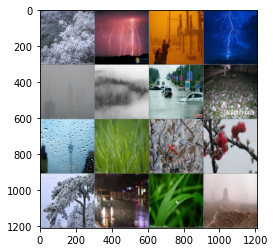

In [2]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))

    print(np_img.shape)
    print((np.transpose(np_img, (1, 2, 0))).shape)

images, labels = trainset[0]

imshow(tv.utils.make_grid(images, nrow=4))
print([f'{dataset.classes[label]} ' for label in labels])
print(dataset.classes)

# CNN 정의 (Basic)

* torch.nn.Conv2d(in_channels, out_channels, kerner_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')

In [3]:
class MyCNN(torch.nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 5, 20, stride=4)
        self.conv2 = torch.nn.Conv2d(5, 10, 20, stride=4)

        self.lin1 = torch.nn.Linear(1690, 512, bias=False)
        self.lin2 = torch.nn.Linear(512, 128, bias=False)
        self.lin3 = torch.nn.Linear(128, len(dataset.classes), bias=False)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.ReLU()(x)
        x = self.conv2(x)

        x = torch.flatten(x, 1)

        x = self.lin1(x)
        x = torch.nn.ReLU()(x)
        x = self.lin2(x)
        x = torch.nn.ReLU()(x)
        x = self.lin3(x)
        x = self.softmax(x)
        return x

myCNN = MyCNN().to('cuda')
optim = torch.optim.Adam(myCNN.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()

# 학습

In [4]:
EPOCH = 100
BEST_MODEL = { 'params': 0, 'loss'  : 10000 }

for epoch in range(EPOCH):
    myCNN.train()
    for train_dat in trainset:
        img_bat, label_bat = train_dat[0].to('cuda'), train_dat[1].to('cuda')
        
        out = myCNN(img_bat)
        bat_loss = loss(out, label_bat)

        optim.zero_grad()
        bat_loss.backward()
        optim.step()

    myCNN.eval()
    val_loss = []
    val_acc = [0, 0] #[correct, total]
    for val_dat in valset:
        img_bat, label_bat = val_dat[0].to('cuda'), val_dat[1].to('cuda')

        out = myCNN(img_bat)
        answers = torch.argmax(out, dim=1)
        mark = (answers == label_bat).to('cpu')
        val_acc[0] += torch.sum(mark).item()
        val_acc[1] += mark.shape[0]
        
        bat_loss = loss(out, label_bat)
        val_loss.append(bat_loss.detach().to('cpu'))

    val_loss = sum(val_loss) / len(val_loss)
    val_acc = val_acc[0] / val_acc[1]

    print(f'[Epoch {epoch+1:3d}] Validation loss: {val_loss:6.4f} / Validation accuracy: {val_acc:5.4f}')

    if BEST_MODEL['loss'] > val_loss:
        print('It is best model. Saving the parameters.')
        BEST_MODEL['loss'] = val_loss
        BEST_MODEL['params'] = myCNN.state_dict()

[Epoch   1] Validation loss: 2.0470 / Validation accuracy: 0.4985
It is best model. Saving the parameters.
[Epoch   2] Validation loss: 2.0236 / Validation accuracy: 0.5174
It is best model. Saving the parameters.
[Epoch   3] Validation loss: 2.0424 / Validation accuracy: 0.4971
[Epoch   4] Validation loss: 1.9922 / Validation accuracy: 0.5538
It is best model. Saving the parameters.
[Epoch   5] Validation loss: 1.9905 / Validation accuracy: 0.5494
It is best model. Saving the parameters.
[Epoch   6] Validation loss: 1.9920 / Validation accuracy: 0.5538
[Epoch   7] Validation loss: 1.9867 / Validation accuracy: 0.5596
It is best model. Saving the parameters.
[Epoch   8] Validation loss: 1.9688 / Validation accuracy: 0.5727
It is best model. Saving the parameters.
[Epoch   9] Validation loss: 1.9853 / Validation accuracy: 0.5567
[Epoch  10] Validation loss: 1.9505 / Validation accuracy: 0.5916
It is best model. Saving the parameters.
[Epoch  11] Validation loss: 1.9766 / Validation accu

# 테스트

In [5]:
myCNN.load_state_dict(BEST_MODEL['params'])

myCNN.eval()
test_loss = []
test_acc = [0, 0]

for test_dat in testset:
    img_bat, label_bat = test_dat[0].to('cuda'), test_dat[1].to('cuda')

    out = myCNN(img_bat)
    answers = torch.argmax(out, dim=1)
    mark = (answers == label_bat).to('cpu')
    test_acc[0] += torch.sum(mark).item()
    test_acc[1] += mark.shape[0]

    bat_loss = loss(out, label_bat)
    test_loss.append(bat_loss.detach().to('cpu'))

test_loss = sum(test_loss) / len(test_loss)
test_acc = test_acc[0] / test_acc[1]

print(f'[Test result] loss: {test_loss:6.4f} / accuracy: {test_acc:5.4f}')

[Test result] loss: 1.9280 / accuracy: 0.6122
